In [10]:
import numpy as np
import scipy
import scipy as sp
import scipy.sparse as sps
import queue
import scipy.constants as spc
import matplotlib.pyplot as plt

In [ ]:
a    = 5.431
hbar  = spc.hbar
           
_2pi_over_a = 2*np.pi / a
sqrt3 = np.sqrt(3)

# params from (Phys. Rev. B 69 115201 (2004)

# two-centre Slater–Koster integrals
V = {
    'ss_sigma'      : -1.95933,
    's_star_s_star' : -4.24135,
    'ss_star_sigma' : -1.52230,
    'sp_sigma'      :  3.02562,
    's_star_p_sigma':  3.15565,
    'sd_sigma'      : -2.28485,
    's_star_d_sigma': -0.80993,
    'pp_sigma'      :  4.10364,
    'pp_pi'         : -1.51801,
    'pd_sigma'      : -1.35554,
    'pd_pi'         :  2.38479,
    'dd_sigma'      : -1.68136,
    'dd_pi'         :  2.58880,
    'dd_delta'      : -1.81400,
    
    'h_si_ss': -4.859509,
    'h_si_sp': 3.776178,
    'h_si_ss*': 0,
    'h_si_sd': -.007703,

    # atomic spin-orbit coupling (p-manifold)
    'SOC'           :  0.01989
}

# on-site energies 

E = {
    's'   : -2.15168,
    'px'  :  4.22925, 'py' : 4.22925, 'pz' : 4.22925,
    'dxy' : 13.78950, 'dyz': 13.78950, 'dzx': 13.78950,
    'dx2y2':13.78950, 'dz2': 13.78950,
    's*'  : 19.11650, 'HS' : -3.056510, 'delta_Si' : -0.276789, 'sp3': 20
}



H_SK = {
        ('s',  's')      : lambda l,m,n,V:  V['h_si_ss'],
    ('s',  's*')     : lambda l,m,n,V:  V['h_si_ss*'],
    ('s*', 's')      : lambda l,m,n,V:  V['h_si_ss*'],

    # ---------------- s – p  -----------------------
    ('s',  'px')     : lambda l,m,n,V:  l * V['h_si_sp'],
    ('px', 's')      : lambda l,m,n,V: -l * V['h_si_sp'],
    ('s',  'py')     : lambda l,m,n,V:  m * V['h_si_sp'],
    ('py', 's')      : lambda l,m,n,V: -m * V['h_si_sp'],
    ('s',  'pz')     : lambda l,m,n,V:  n * V['h_si_sp'],
    ('pz', 's')      : lambda l,m,n,V: -n * V['h_si_sp'],


    # ---------------- s – d  -----------------------
    ('s','dxy')      : lambda l,m,n,    V:  sqrt3*l*m               * V['h_si_sd'],
    ('dxy','s')      : lambda l,m,n,V:  sqrt3*l*m               * V['h_si_sd'],
    ('s','dyz')      : lambda l,m,n,V:  sqrt3*m*n               * V['h_si_sd'],
    ('dyz','s')      : lambda l,m,n,V:  sqrt3*m*n               * V['h_si_sd'],
    ('s','dzx')      : lambda l,m,n,V:  sqrt3*n*l               * V['h_si_sd'],
    ('dzx','s')      : lambda l,m,n,V:  sqrt3*n*l               * V['h_si_sd'],
    ('s','dx2y2')    : lambda l,m,n,V: (sqrt3/2)*(l**2-m**2)    * V['h_si_sd'],
    ('dx2y2','s')    : lambda l,m,n,V: (sqrt3/2)*(l**2-m**2)    * V['h_si_sd'],
    ('s','dz2')      : lambda l,m,n,V:  0.5*(3*n**2-1)          * V['h_si_sd'],
    ('dz2','s')      : lambda l,m,n,V:  0.5*(3*n**2-1)          * V['h_si_sd'],

}


SK = {
    # ---------------- s / s* blocks ----------------
    ('s',  's')      : lambda l,m,n,V:  V['ss_sigma'],
    ('s',  's*')     : lambda l,m,n,V:  V['ss_star_sigma'],
    ('s*', 's')      : lambda l,m,n,V:  V['ss_star_sigma'],
    ('s*', 's*')     : lambda l,m,n,V:  V['s_star_s_star'],

    # ---------------- s – p  -----------------------
    ('s',  'px')     : lambda l,m,n,V:  l * V['sp_sigma'],
    ('px', 's')      : lambda l,m,n,V: -l * V['sp_sigma'],
    ('s',  'py')     : lambda l,m,n,V:  m * V['sp_sigma'],
    ('py', 's')      : lambda l,m,n,V: -m * V['sp_sigma'],
    ('s',  'pz')     : lambda l,m,n,V:  n * V['sp_sigma'],
    ('pz', 's')      : lambda l,m,n,V: -n * V['sp_sigma'],

    # ---------------- s* – p  ----------------------
    ('s*','px')      : lambda l,m,n,V:  l * V['s_star_p_sigma'],
    ('px','s*')      : lambda l,m,n,V: -l * V['s_star_p_sigma'],
    ('s*','py')      : lambda l,m,n,V:  m * V['s_star_p_sigma'],
    ('py','s*')      : lambda l,m,n,V: -m * V['s_star_p_sigma'],
    ('s*','pz')      : lambda l,m,n,V:  n * V['s_star_p_sigma'],
    ('pz','s*')      : lambda l,m,n,V: -n * V['s_star_p_sigma'],

    # ---------------- s – d  -----------------------
    ('s','dxy')      : lambda l,m,n,    V:  sqrt3*l*m               * V['sd_sigma'],
    ('dxy','s')      : lambda l,m,n,V:  sqrt3*l*m               * V['sd_sigma'],
    ('s','dyz')      : lambda l,m,n,V:  sqrt3*m*n               * V['sd_sigma'],
    ('dyz','s')      : lambda l,m,n,V:  sqrt3*m*n               * V['sd_sigma'],
    ('s','dzx')      : lambda l,m,n,V:  sqrt3*n*l               * V['sd_sigma'],
    ('dzx','s')      : lambda l,m,n,V:  sqrt3*n*l               * V['sd_sigma'],
    ('s','dx2y2')    : lambda l,m,n,V: (sqrt3/2)*(l**2-m**2)    * V['sd_sigma'],
    ('dx2y2','s')    : lambda l,m,n,V: (sqrt3/2)*(l**2-m**2)    * V['sd_sigma'],
    ('s','dz2')      : lambda l,m,n,V:  0.5*(3*n**2-1)          * V['sd_sigma'],
    ('dz2','s')      : lambda l,m,n,V:  0.5*(3*n**2-1)          * V['sd_sigma'],

    # ---------------- s* – d  ----------------------
    ('s*','dxy')     : lambda l,m,n,V:  sqrt3*l*m               * V['s_star_d_sigma'],
    ('dxy','s*')     : lambda l,m,n,V:  sqrt3*l*m               * V['s_star_d_sigma'],
    ('s*','dyz')     : lambda l,m,n,V:  sqrt3*m*n               * V['s_star_d_sigma'],
    ('dyz','s*')     : lambda l,m,n,V:  sqrt3*m*n               * V['s_star_d_sigma'],
    ('s*','dzx')     : lambda l,m,n,V:  sqrt3*n*l               * V['s_star_d_sigma'],
    ('dzx','s*')     : lambda l,m,n,V:  sqrt3*n*l               * V['s_star_d_sigma'],
    ('s*','dx2y2')   : lambda l,m,n,V: (sqrt3/2)*(l**2-m**2)    * V['s_star_d_sigma'],
    ('dx2y2','s*')   : lambda l,m,n,V: (sqrt3/2)*(l**2-m**2)    * V['s_star_d_sigma'],
    ('s*','dz2')     : lambda l,m,n,V:  0.5*(3*n**2-1)          * V['s_star_d_sigma'],
    ('dz2','s*')     : lambda l,m,n,V:  0.5*(3*n**2-1)          * V['s_star_d_sigma'],

    # ---------------- p – p  -----------------------
    ('px','px')      : lambda l,m,n,V:  l**2 * V['pp_sigma'] + (1-l**2) * V['pp_pi'],
    ('py','py')      : lambda l,m,n,V:  m**2 * V['pp_sigma'] + (1-m**2) * V['pp_pi'],
    ('pz','pz')      : lambda l,m,n,V:  n**2 * V['pp_sigma'] + (1-n**2) * V['pp_pi'],
    ('px','py')      : lambda l,m,n,V:  l*m * (V['pp_sigma'] - V['pp_pi']),
    ('py','px')      : lambda l,m,n,V:  l*m * (V['pp_sigma'] - V['pp_pi']),
    ('px','pz')      : lambda l,m,n,V:  l*n * (V['pp_sigma'] - V['pp_pi']),
    ('pz','px')      : lambda l,m,n,V:  l*n * (V['pp_sigma'] - V['pp_pi']),
    ('py','pz')      : lambda l,m,n,V:  m*n * (V['pp_sigma'] - V['pp_pi']),
    ('pz','py')      : lambda l,m,n,V:  m*n * (V['pp_sigma'] - V['pp_pi']),

    # ---------------- p – d  (all 30 = 15×2) --------
    ('px','dxy')     : lambda l,m,n,V:  sqrt3*l**2*m                * V['pd_sigma']
                                       + m*(1-2*l**2)              * V['pd_pi'],
    ('dxy','px')     : lambda l,m,n,V:  sqrt3*l**2*m                * -V['pd_sigma']
                                       + m*(1-2*l**2)              * -V['pd_pi'],

    ('px','dyz')     : lambda l,m,n,V:  sqrt3*l*m*n                 * V['pd_sigma']
                                       - 2*l*m*n                   * V['pd_pi'],
    ('dyz','px')     : lambda l,m,n,V:  sqrt3*l*m*n                 * -V['pd_sigma']
                                       - 2*l*m*n                   * -V['pd_pi'],

    ('px','dzx')     : lambda l,m,n,V:  sqrt3*l**2*n                * V['pd_sigma']
                                       + n*(1-2*l**2)              * V['pd_pi'],
    ('dzx','px')     : lambda l,m,n,V:  sqrt3*l**2*n                * -V['pd_sigma']
                                       + n*(1-2*l**2)              * -V['pd_pi'],

    ('px','dx2y2')   : lambda l,m,n,V: (sqrt3/2)*l*(l**2-m**2)      * V['pd_sigma']
                                       + l*(1-l**2 + m**2)             * V['pd_pi'],
    ('dx2y2','px')   : lambda l,m,n,V: (sqrt3/2)*l*(l**2-m**2)      * -V['pd_sigma']
                                       + l*(1-l**2 + m**2)             * -V['pd_pi'],

    ('px','dz2')     : lambda l,m,n,V:  l*(n**2 - 0.5*(l**2+m**2))             * V['pd_sigma']
                                      -sqrt3 * l * n**2              * V['pd_pi'],
    ('dz2','px')     : lambda l,m,n,V: l*(n**2 - 0.5*(l**2+m**2))             * -V['pd_sigma']
                                      -sqrt3 * l * n**2                * -V['pd_pi'],

    ('py','dxy')     : lambda l,m,n,V:  sqrt3*l*m**2                * V['pd_sigma']
                                       + l*(1-2*m**2)              * V['pd_pi'],
    ('dxy','py')     : lambda l,m,n,V:  sqrt3*l*m**2                * -V['pd_sigma']
                                       + l*(1-2*m**2)              * -V['pd_pi'],

    ('py','dyz')     : lambda l,m,n,V:  sqrt3*m**2*n         * V['pd_sigma']
                                       + n*(1-2*m**2)            * V['pd_pi'],
    ('dyz','py')     : lambda l,m,n,V:  sqrt3*m**2*n          * -V['pd_sigma']
                                       + n*(1-2*m**2)            * -V['pd_pi'],

    ('py','dzx')     : lambda l,m,n,V:  sqrt3*l*m*n                 * V['pd_sigma']
                                       - 2*l*m*n                   * V['pd_pi'],
    ('dzx','py')     : lambda l,m,n,V:  sqrt3*l*m*n                 * -V['pd_sigma']
                                       - 2*l*m*n                   * -V['pd_pi'],

    ('py','dx2y2')   : lambda l,m,n,V: (sqrt3/2)*m*(m**2-l**2)      * V['pd_sigma']
                                       - m*(1 + l**2 -m**2)             * V['pd_pi'],
    ('dx2y2','py')   : lambda l,m,n,V: (sqrt3/2)*m*(m**2-l**2)      * -V['pd_sigma']
                                       - m*(1 + l**2 -m**2)             * -V['pd_pi'],

    ('py','dz2')     : lambda l,m,n,V: m * (n**2 - (l**2 + m**2 ) /2)              * V['pd_sigma']
                                       -sqrt3 * m * n**2                * V['pd_pi'],
    ('dz2','py')     : lambda l,m,n,V: m * (n**2 - (l**2 + m**2 ) /2)               * -V['pd_sigma']
                                       -sqrt3 * m * n**2                 * -V['pd_pi'],

    ('pz','dxy')     : lambda l,m,n,V:  sqrt3*l*m*n                 * V['pd_sigma']
                                       - 2*l*m*n                   * V['pd_pi'],
    ('dxy','pz')     : lambda l,m,n,V:  sqrt3*l*m*n                 * -V['pd_sigma']
                                       - 2*l*m*n                   * -V['pd_pi'],

    ('pz','dyz')     : lambda l,m,n,V:  sqrt3*n**2*m                * V['pd_sigma']
                                       + m*(1-2*n**2)              * V['pd_pi'],
    ('dyz','pz')     : lambda l,m,n,V:  sqrt3*n**2*m                * -V['pd_sigma']
                                       + m*(1-2*n**2)              * -V['pd_pi'],

    ('pz','dzx')     : lambda l,m,n,V:  sqrt3*l*n**2                * V['pd_sigma']
                                       + l*(1-2*n**2)              * V['pd_pi'],
    ('dzx','pz')     : lambda l,m,n,V:  sqrt3*l*n**2                * -V['pd_sigma']
                                       + l*(1-2*n**2)              * -V['pd_pi'],

    ('pz','dx2y2')   : lambda l,m,n,V: (sqrt3/2)*n*(l**2-m**2)      * V['pd_sigma']
                                       - n*(l**2-m**2)      * V['pd_pi'],
    ('dx2y2','pz')   : lambda l,m,n,V: (sqrt3/2)*n*(l**2-m**2)      * -V['pd_sigma']
                                       - n*(l**2-m**2)     * -V['pd_pi'],
                                       
    ('pz','dz2')     : lambda l,m,n,V: n*(n**2 - 0.5*(l**2+m**2))             * V['pd_sigma']
                                       + sqrt3 * n * (l**2 + m**2)                   * V['pd_pi'],
    ('dz2','pz')     : lambda l,m,n,V: n*(n**2 - 0.5*(l**2+m**2))             * -V['pd_sigma']
                                        + sqrt3 * n * (l**2 + m**2)              * -V['pd_pi'],

    # ---------------- d – d  (15 independent + symmetry) ----------
    # ---- diagonals ----
    ('dxy','dxy')    : lambda l,m,n,V: 3*l**2*m**2                    * V['dd_sigma']
                                       + (l**2+m**2-4*l**2*m**2)     * V['dd_pi']
                                       + (n**2 + l**2*m**2)          * V['dd_delta'],

    ('dyz','dyz')    : lambda l,m,n,V: 3*m**2*n**2                    * V['dd_sigma']
                                       + (m**2+n**2-4*m**2*n**2)     * V['dd_pi']
                                       + (l**2 + m**2*n**2)          * V['dd_delta'],

    ('dzx','dzx')    : lambda l,m,n,V: 3*l**2*n**2                    * V['dd_sigma']
                                       + (l**2+n**2-4*l**2*n**2)     * V['dd_pi']
                                       + (m**2 + l**2*n**2)          * V['dd_delta'],

    ('dx2y2','dx2y2'): lambda l,m,n,V: 0.75*(l**2-m**2)**2            * V['dd_sigma']
                                       + (l**2+m**2-(l**2-m**2)**2)  * V['dd_pi']
                                       + (n**2+0.25*(l**2-m**2)**2)  * V['dd_delta'],

    ('dz2','dz2')    : lambda l,m,n,V: (n**2-0.5*(l**2+m**2))**2      * V['dd_sigma']
                                       + 3*n**2*(l**2+m**2)          * V['dd_pi']
                                       + 0.75*(l**2+m**2)**2         * V['dd_delta'],

    # ---- off-diagonals (each listed once; symmetry implied) ----
    ('dxy','dyz')    : lambda l,m,n,V: 3*l*m**2*n                     * V['dd_sigma']
                                       + l*n*(1-4*m**2)              * V['dd_pi']
                                       + l*n*(m**2-1)                * V['dd_delta'],
    ('dyz','dxy')    : lambda l,m,n,V: 3*l*m**2*n                     * V['dd_sigma']
                                       + l*n*(1-4*m**2)              * V['dd_pi']
                                       + l*n*(m**2-1)                * V['dd_delta'],

    ('dxy','dzx')    : lambda l,m,n,V: 3*m*n*l**2                     * V['dd_sigma']
                                       + m*n*(1-4*l**2)              * V['dd_pi']
                                       + m*n*(l**2-1)                * V['dd_delta'],
    ('dzx','dxy')    : lambda l,m,n,V: 3*m*n*l**2                     * V['dd_sigma']
                                       + m*n*(1-4*l**2)              * V['dd_pi']
                                       + m*n*(l**2-1)                * V['dd_delta'],

    ('dxy','dx2y2')  : lambda l,m,n,V: 1.5*l*m*(l**2-m**2)            * V['dd_sigma']
                                       + 2*l*m*(m**2-l**2)           * V['dd_pi']
                                       + 0.5*l*m*(l**2-m**2)         * V['dd_delta'],
    ('dx2y2','dxy')  : lambda l,m,n,V: 1.5*l*m*(l**2-m**2)            * V['dd_sigma']
                                       + 2*l*m*(m**2-l**2)           * V['dd_pi']
                                       + 0.5*l*m*(l**2-m**2)         * V['dd_delta'],

    ('dxy','dz2')    : lambda l,m,n,V: sqrt3*l*m*(n**2-0.5*(l**2+m**2))*V['dd_sigma']
                                       -2*sqrt3*l*m*n**2             * V['dd_pi']
                                       +0.5*sqrt3*l*m*(1+n**2)       * V['dd_delta'],
    ('dz2','dxy')    : lambda l,m,n,V: sqrt3*l*m*(n**2-0.5*(l**2+m**2))*V['dd_sigma']
                                       -2*sqrt3*l*m*n**2             * V['dd_pi']
                                       +0.5*sqrt3*l*m*(1+n**2)       * V['dd_delta'],

    ('dyz','dzx')    : lambda l,m,n,V: 3*l*m*n**2                     * V['dd_sigma']
                                       + l*m*(1-4*n**2)              * V['dd_pi']
                                       + l*m*(n**2-1)                * V['dd_delta'],
    ('dzx','dyz')    : lambda l,m,n,V: 3*l*m*n**2                     * V['dd_sigma']
                                       + l*m*(1-4*n**2)              * V['dd_pi']
                                       + l*m*(n**2-1)                * V['dd_delta'],

    ('dyz','dx2y2')  : lambda l,m,n,V: 1.5*m*n*(l**2-m**2)            * V['dd_sigma']
                                       - m*n*(1+2*(l**2-m**2))       * V['dd_pi']
                                       + m*n*(1+0.5*(l**2-m**2))     * V['dd_delta'],
    ('dx2y2','dyz')  : lambda l,m,n,V: 1.5*m*n*(l**2-m**2)            * V['dd_sigma']
                                       - m*n*(1+2*(l**2-m**2))       * V['dd_pi']
                                       + m*n*(1+0.5*(l**2-m**2))     * V['dd_delta'],

    ('dyz','dz2')    : lambda l,m,n,V: sqrt3*m*n*(n**2-0.5*(l**2+m**2))*V['dd_sigma']
                                       + sqrt3*m*n*(l**2+m**2-n**2) * V['dd_pi']
                                       - 0.5*sqrt3*m*n*(l**2+m**2)  * V['dd_delta'],
    ('dz2','dyz')    : lambda l,m,n,V: sqrt3*m*n*(n**2-0.5*(l**2+m**2))*V['dd_sigma']
                                       + sqrt3*m*n*(l**2+m**2-n**2) * V['dd_pi']
                                       - 0.5*sqrt3*m*n*(l**2+m**2)  * V['dd_delta'],

    ('dzx','dx2y2')  : lambda l,m,n,V: 1.5*l*n*(l**2-m**2)            * V['dd_sigma']
                                       + n*l*(1-2*(l**2-m**2))       * V['dd_pi']
                                       - n*l*(1-0.5*(l**2-m**2))     * V['dd_delta'],
    ('dx2y2','dzx')  : lambda l,m,n,V: 1.5*l*n*(l**2-m**2)            * V['dd_sigma']
                                       + n*l*(1-2*(l**2-m**2))       * V['dd_pi']
                                       - n*l*(1-0.5*(l**2-m**2))     * V['dd_delta'],

    ('dzx','dz2')    : lambda l,m,n,V: sqrt3*n*l*(n**2-0.5*(l**2+m**2))*V['dd_sigma']
                                       + sqrt3*n*l*(l**2+m**2-n**2) * V['dd_pi']
                                       - 0.5*sqrt3*n*l*(l**2+m**2)  * V['dd_delta'],
    ('dz2','dzx')    : lambda l,m,n,V: sqrt3*n*l*(n**2-0.5*(l**2+m**2))*V['dd_sigma']
                                       + sqrt3*n*l*(l**2+m**2-n**2) * V['dd_pi']
                                       - 0.5*sqrt3*n*l*(l**2+m**2)  * V['dd_delta'],

    ('dx2y2','dz2')  : lambda l,m,n,V: 0.5*sqrt3*(l**2-m**2)*(n**2-0.5*(l**2+m**2))*V['dd_sigma']
                                       + sqrt3*n**2*(m**2-l**2)     * V['dd_pi']
                                       + 0.25*sqrt3*(1+n**2)*(l**2-m**2) * V['dd_delta'],
    ('dz2','dx2y2')  : lambda l,m,n,V: 0.5*sqrt3*(l**2-m**2)*(n**2-0.5*(l**2+m**2))*V['dd_sigma']
                                       + sqrt3*n**2*(m**2-l**2)     * V['dd_pi']
                                       + 0.25*sqrt3*(1+n**2)*(l**2-m**2) * V['dd_delta'],
}



Es = E['s']
Ep = E['px']             

# orbital-basis Hamiltonian
H_orb = np.diag([Es, Ep, Ep, Ep])

# change-of-basis matrices
cob = 0.5*np.array([[1, 1, 1, 1],
                             [1, 1,-1,-1],
                             [1,-1, 1,-1],
                             [1,-1,-1, 1]])
cob = cob.T  


newOrbitals = ['s', 'x1', 'x2', 'x3']
translation = {'s':('s'), 'x1' : ('px', 'dxy'), 'x2': ('py', 'dyz'), 'x3': ('pz', 'dzx')}
orbitalMatrix = np.diag(np.array([E['s'],  E['px'] + E['dxy'], E['px'] +  E['dxy'], E['px'] +  E['dxy']]))

Es = E['s']
Ep = E['px']
Ed = E['dxy']
alpha = np.sqrt(Ep  / (Ep + Ed))
beta = np.sqrt(Ed  / (Ep + Ed)) 
cont1 = 1
cont2 = 0
orbitals = ['s', 'px', 'py', 'pz', 'dxy','dyz','dzx']
factor = {'s': 1, 'px':alpha, 'py':alpha, 'pz':alpha, 'dxy':beta,'dyz':beta,'dzx':beta}
factor2 = {'s': 1, 'px':cont1, 'py':cont1, 'pz':cont1, 'dxy':cont2,'dyz':cont2,'dzx':cont2}
orbitalDangling = ['s', 'px', 'py', 'pz', 'dxy','dyz','dzx']

orbToIndex= {}
for oa, orb in enumerate(orbitalDangling):
    orbToIndex[orb] = oa

def danglingBonds(modifiedMatrix):
    newOrb = np.zeros((7,7))

    for o1, orb1 in enumerate(newOrbitals):
        for o2, orb2 in enumerate(newOrbitals):
            value = modifiedMatrix[o1, o2]
            m1 = translation[orb1]
            m2 = translation[orb2]
            
            if len(m1) == 1 and m1 == m2:
                newOrb[orbToIndex[m1[0]], orbToIndex[m2[0]]] = value*factor[m1[0]] * factor[m2[0]]
                
            elif len(m1) == 2 and m1 == m2:
                newOrb[orbToIndex[m1[0]], orbToIndex[m2[0]]] = value*factor[m1[0]] * factor[m2[0]]
                newOrb[orbToIndex[m1[1]], orbToIndex[m2[1]]] = value*factor[m1[1]] * factor[m2[1]]    
            else:
                for o3 in m1:
                    for o4 in m2:  
                        newOrb[orbToIndex[o3], orbToIndex[o4]] = value*factor[o3] * factor[o4]*factor2[o3] * factor2[o4]
                        newOrb[orbToIndex[o4], orbToIndex[o3]] = value*factor[o3] * factor[o4]*factor2[o3] * factor2[o4]
    return newOrb
ThybridizationMatrix = cob.T @ orbitalMatrix @ cob




In [12]:
class Atom:
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z
  

    def __eq__(self, other):
        if isinstance(other, Atom):
            return self.x == other.x and self.y == other.y and self.z == other.z
        return False
    

    def __hash__(self):
        return hash((self.x, self.y, self.z))

    def __repr__(self):
        return f"Atom({self.x}, {self.y}, {self.z})"
    

class UnitCellGeneration:
    _DELTAS = {                       
        0: [(+0.25,+0.25,+0.25), (+0.25,-0.25,-0.25),
            (-0.25,+0.25,-0.25), (-0.25,-0.25,+0.25)],   # type-0 sub-lattice
        1: [(-0.25,-0.25,-0.25), (-0.25,+0.25,+0.25),
            (+0.25,-0.25,+0.25), (+0.25,+0.25,-0.25)]    # type-1 sub-lattice
    }
    
    
    @staticmethod
    def _delta(a, b):   
        return (b.x - a.x, b.y - a.y, b.z - a.z)

    @staticmethod
    def _sublattice(atom):    
        return (round(atom.x*4) + round(atom.y*4) + round(atom.z*4)) & 1
    

    def __init__(self, N):
        #print(N)
        self.atoms = {}      # basic graph design 
        self.visited = set() # dfs
        self.N = N
        # base node 
        self.addAtoms(Atom(0, 0, 0), 0)
        self.periodicityFix = {}
        self.atoms_nonPeriodic = self.atoms.copy()
        
        self.hydrogens = {}
        self.numHydrogens = 0

        for atom in self.atoms:
            
            listofatoms = self.atoms[atom]
            for i in listofatoms:
              
                value = i
                if not self.checkIfAllowed(value):
                    # we need to update the periodic neighbor
                    delta = (value.x - atom.x, value.y - atom.y, value.z - atom.z)
                    try:
                        newNeighbor = Atom((atom.x + delta[0]) % 1, (atom.y + delta[1]) % 1, (atom.z + delta[2]))
                        self.atoms[newNeighbor].append(atom)
                       
                    except:
                        print(atom, value, newNeighbor)
                        return 
                    
            

            self.atoms[atom] = list(filter(self.checkIfAllowed, self.atoms[atom]))
            
            self.hydrogen_passification()
            


    def checkIfAllowed(self, newAtom):
        # check if atoms are in proper cell 
        return not (newAtom.x < 0 or newAtom.y < 0 or newAtom.z < 0 or newAtom.z >= self.N or newAtom.x >= 1 or newAtom.y >= 1)
        
    def checkIfAllowedInZDirection(self, newAtom):
        return not (newAtom.z < 0 or newAtom.z >= self.N)

    def addAtoms(self, base, atomType):
        # dfs 
        if base in self.visited:
            return
        self.visited.add(base)

        if atomType == 0:
            atom1 = Atom(base.x + 0.25, base.y + 0.25, base.z + 0.25)
            atom2 = Atom(base.x + 0.25, base.y - 0.25, base.z - 0.25)
            atom3 = Atom(base.x - 0.25, base.y + 0.25, base.z - 0.25)
            atom4 = Atom(base.x - 0.25, base.y - 0.25, base.z + 0.25)
        elif atomType == 1:
            atom1 = Atom(base.x - 0.25, base.y - 0.25, base.z - 0.25)
            atom2 = Atom(base.x - 0.25, base.y + 0.25, base.z + 0.25)
            atom3 = Atom(base.x + 0.25, base.y - 0.25, base.z + 0.25)
            atom4 = Atom(base.x + 0.25, base.y + 0.25, base.z - 0.25)
        else:
            return

        newAtoms = [atom1, atom2, atom3, atom4]
        
        for newAtom in newAtoms:
            
            # If base has no neighbors yet, initialize its neighbor list.
            if self.checkIfAllowedInZDirection(newAtom):
                if base not in self.atoms:
                    self.atoms[base] = [newAtom]
                elif newAtom not in self.atoms[base]:
                    self.atoms[base].append(newAtom)
            
            # Recursively add neighbors (DFS)
            if self.checkIfAllowed(newAtom):
                self.addAtoms(newAtom, (atomType + 1) % 2)
                


    def neighborTable(self): # finds the directional cosines: 
        neighborInformation = {}
        for atom in self.atoms:
            neighborInformation[atom] = {}
            for i in range(len(self.atoms[atom])):
                nonPeriodicNeighbor = self.atoms_nonPeriodic[atom][i]
     
                # Compute the difference vector between neighbor and atom.
                dx = nonPeriodicNeighbor.x - atom.x
                dy = nonPeriodicNeighbor.y - atom.y
                dz = nonPeriodicNeighbor.z - atom.z
                
                delta = (dx, dy, dz)
                newNeighbor = Atom((atom.x + delta[0]) % 1, (atom.y + delta[1]) % 1, (atom.z + delta[2]))
                norm = np.sqrt(dx**2 + dy**2 + dz**2)
                
                # Calculate the directional cosines: l, m, n.
                if norm != 0:
                    l = dx / norm
                    m = dy / norm
                    n = dz / norm
                else:
                    l, m, n = 0.0, 0.0, 0.0
                
                neighborInformation[atom].update({newNeighbor: (delta, l, m, n)})
        
        return neighborInformation
    
    def hydrogen_passification(self):
        # we need to give each hydrogen an index 
        hydrogenIndex = 0
        for atom in self.atoms:
            missing = self.dangling_bonds(atom, only_z=True)
            for hydrogen_ in missing:
                #print(f"silicon atom is: {atom} hydrogen atom is {hydrogen_}")
                
                hydrogen = Atom(hydrogen_[0] + atom.x, hydrogen_[1]+ atom.y, hydrogen_[2] + + atom.z)
                dx,dy,dz = hydrogen_
                norm = np.sqrt(dx**2 + dy**2 + dz**2)
                l = dx / norm
                m = dy / norm
                n = dz / norm
                self.hydrogens[hydrogen] = [atom, hydrogen_, hydrogenIndex, l,m,n]
                hydrogenIndex += 1
                
                
    
    def dangling_bonds(self, atom, only_z= False):
        """
        Return the list of bond-direction vectors that *should* exist for
        `atom` but do not (because the neighbour lies outside the slab).
        """
        missing = []
        for dx, dy, dz in self._DELTAS[self._sublattice(atom)]:
            nx, ny, nz = atom.x + dx, atom.y + dy, atom.z + dz

            # check if it is outside the cell in z direction 
            if nz < 0 or nz >= self.N:
                missing.append((dx, dy, dz))
                continue
            if only_z == False:
                n_atom = Atom(nx % 1, ny % 1, nz)   # wrap in x, y (periodic)
                if n_atom not in self.atoms:        
                    missing.append((dx, dy, dz))

        return missing     
    
    def create_linear_potential(self, V):
        linear_potential = lambda i, V : i / (self.N) * V
        #print(self.N)
        potential = np.array([linear_potential(i, V) for i in range(self.N * 4 + 1)])
        #print(potential)
        return potential
    # OLD
    
    def determine_hybridization(signs):
        # Extract just the signs
        sign_pattern = np.sign(signs)
        
        # Ensure first sign (s orbital) is positive for consistent comparison
        if sign_pattern[0] < 0:
            sign_pattern = -sign_pattern
        
        # Map each sign pattern to its hybridization index
        if np.array_equal(sign_pattern, [1, 1, 1, 1]):       # Type a
            return 0
        elif np.array_equal(sign_pattern, [1, 1, -1, -1]):   # Type b
            return 1
        elif np.array_equal(sign_pattern, [1, -1, 1, -1]):   # Type c
            return 2
        elif np.array_equal(sign_pattern, [1, -1, -1, 1]):   # Type d
            return 3
        
        return None 
        
        
    def __str__(self):
        s = ""
        for atom, neighbors in self.atoms.items():
            s += f"{atom} -> {neighbors}" + "\n"
            
        return s
    


In [21]:
def create_tight_binding(k, N=1, potentialProfile = None):
    kx,ky = k
    
    #print(N)
    unitCell = UnitCellGeneration(N)
    if potentialProfile is None:
        potentialProfile = unitCell.create_linear_potential(0)
    unitNeighbors = unitCell.neighborTable()
    hydrogens = unitCell.hydrogens
    
    
    
    numSilicon = len(unitNeighbors.keys())
    numHydrogen = len(hydrogens.keys()) 
   
    orbitals = ['s', 'px', 'py', 'pz', 'dxy','dyz','dzx','dx2y2','dz2', 's*']
    numOrbitals = len(orbitals)
    size = numSilicon * numOrbitals + numHydrogen * 0
    A = np.zeros((size, size), dtype=complex)    
    
    atomToIndex = {}
    indexToAtom = {}
    for atom_index,atom in enumerate(unitNeighbors):
        atomToIndex[atom] = atom_index
        indexToAtom[atom_index] = atom
    
    
    """
    for atom_index in range(numSilicon):
        for orbIndex, orbital in enumerate(orbitals):
            index = atom_index * 10 + orbIndex
            #print(orbital)
            A[index, index] += E[orbital]

    
    
    for hydrogen in hydrogens.keys():
        information = hydrogens[hydrogen]
        silicon, delta, hIndex, l,m,n = information
        
        siliconIndex = atomToIndex[silicon] #what atom is silicon 
        hydrogenIndex = numSilicon *numOrbitals + hIndex -1
        
        # first update onsite energies of the two 
        for i in range(siliconIndex * numOrbitals, (siliconIndex + 1) * numOrbitals):
            A[i,i] += E['delta_Si']
        
    
        A[hydrogenIndex,hydrogenIndex] += E['HS']
        
        for orbIndex, orb in enumerate(orbitals):
            index_i = hydrogenIndex 
            index_j = siliconIndex * numOrbitals + orbIndex
            hop = H_SK[('s', orb)](l, m, n, V)
            A[index_i,index_j] += hop
            
            A[index_j, index_i] += hop"""
            
            

    # old code with sp3 hybridization 
    for atom_idx, atom in indexToAtom.items():
        hybridizationMatrix = TheHybridizationMatrix.copy() 

        for delta in unitCell.dangling_bonds(atom):
            signs = np.array([1/4] + list(delta)) * 4
            h = UnitCellGeneration.determine_hybridization(signs)
            hybridizationMatrix[h, h] += E['sp3']          # increase the energy of dangling states 
        
        # if there are no dangling bonds this returns the standard diag matrix with onsite energies 
        onsiteMatrix = cob @ hybridizationMatrix @ cob.T # go back to orbital basis 
        newOnsite = danglingBonds(onsiteMatrix)
        A[atom_idx*10:atom_idx*10 + 7, atom_idx*10:atom_idx*10 + 7] = newOnsite
        A[atom_idx*10 + 7:atom_idx*10 + 9, atom_idx*10 + 7:atom_idx*10 + 9] = np.eye(2) * E['dxy']
        A[atom_idx*10 + 9,atom_idx*10 + 9] = E['s*']
    
    for atom_index in range(numSilicon):
        atom = indexToAtom[atom_index]
        neighbors = unitNeighbors[atom]
        for orbitalIndex, orbital in enumerate(orbitals):
            index_i = atom_index * numOrbitals + orbitalIndex
            effectiveZinPotential = int(atom.z * 4)
            
            #print(effectiveZinPotential)
            #print(potentialProfile)
            
            A[index_i,index_i] += potentialProfile[effectiveZinPotential]
            
            
            for neighbor in neighbors.keys():
                delta = neighbors[neighbor][0]
                l,m,n = neighbors[neighbor][1:]
                phase = np.exp(2 * np.pi * 1j * (kx*delta[0] + ky*delta[1])) # blochs theorem does not work 
                
                neighbor_index = atomToIndex[neighbor]       
                
                for secOrbitalIndex, secondOrbital in enumerate(orbitals):
                    index_j = neighbor_index * numOrbitals + secOrbitalIndex
                    
                    hop = SK[(orbital, secondOrbital)](l, m, n, V)
                   
                    A[index_i,index_j] += hop * phase   
            
                
        dagger = lambda A: np.conjugate(A.T)
    if not np.allclose(A, dagger(A)):
        print("H isnt Hermitian")

    eigvals,eigv = np.linalg.eigh(A)
    return eigvals, A
    


import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla


def create_tight_binding_sparse(k, N=1, potentialProfile=None, sigma=0.5, eigRange=10):
    kx,ky = k
    
    #print(N)
    unitCell = UnitCellGeneration(N)
    if potentialProfile is None:
        potentialProfile = unitCell.create_linear_potential(0)
    unitNeighbors = unitCell.neighborTable()
    hydrogens = unitCell.hydrogens
    
    
    
    numSilicon = len(unitNeighbors.keys())
    numHydrogen = len(hydrogens.keys()) 
   
    orbitals = ['s', 'px', 'py', 'pz', 'dxy','dyz','dzx','dx2y2','dz2', 's*']
    numOrbitals = len(orbitals)
    size = numSilicon * numOrbitals + numHydrogen * 0
    
    atomToIndex = {}
    indexToAtom = {}
    for atom_index,atom in enumerate(unitNeighbors):
        atomToIndex[atom] = atom_index
        indexToAtom[atom_index] = atom

    rows, cols, data = [], [], []                   # <-- sparse triplets

    # helper -----------------------------------------------------------
    def add(i, j, val):
        if val != 0.0:
            rows.append(i); cols.append(j); data.append(val)
            if i != j:                              # Hermitian
                rows.append(j); cols.append(i); data.append(np.conj(val))
    # ------------------------------------------------------------------

    # ---------- on‑site (Si) ----------
    
    for atom_idx, atom in indexToAtom.items():
        hybridizationMatrix = TheHybridizationMatrix.copy() 

        for delta in unitCell.dangling_bonds(atom):
            signs = np.array([1/4] + list(delta)) * 4
            h = UnitCellGeneration.determine_hybridization(signs)
            hybridizationMatrix[h, h] += E['sp3']          # increase the energy of dangling states 
    
        # if there are no dangling bonds this returns the standard diag matrix with onsite energies 
        onsiteMatrix = cob @ hybridizationMatrix @ cob.T # go back to orbital basis 
        onsiteMatrix = danglingBonds(onsiteMatrix)
        base = atom_idx * numOrbitals
        for i in range(7):
            for j in range(i ,7):
                add(base + i, base + j, onsiteMatrix[i,j])
        for p in range(7, 9):                       # five d’s
            add(base + p, base + p, E['dxy'])
        add(base + 9, base + 9, E['s*'])
        
    for atom_index, atom in indexToAtom.items():
        base_i = atom_index * numOrbitals
        for neighbor, (delta, l, m, n) in unitNeighbors[atom].items():

            j = atomToIndex[neighbor]
            if j < atom_index:              # upper‑triangle filter
                continue                    # let add() mirror it

            phase = np.exp(2j*np.pi*(kx*delta[0] + ky*delta[1]))

            for o1, orb1 in enumerate(orbitals):
                for o2, orb2 in enumerate(orbitals):
                    hop = SK[(orb1, orb2)](l, m, n, V) * phase
                    add(base_i + o1, j*numOrbitals + o2, hop)

            
  
    H = sp.coo_matrix((data, (rows, cols)), shape=(size, size)).tocsr()
    eigvals, eigvecs = spla.eigsh(H, k=eigRange,
                              sigma=sigma, which='LM', tol=1e-6)


    return eigvals, H


def eigvals_near_gap(H, sigma, k_keep, v0=None, tol=1e-6):
    """
    Return eigenvalues closest to `sigma` (mid‑gap) using shift–invert.

    Parameters
    ----------
    H        :  csr_matrix  (Hermitian)
    sigma    :  float       – target energy (eV)
    k_keep   :  int         – # eigenpairs to keep around σ
    v0       :  ndarray or None  –  initial guess for ARPACK
    """
    w, v = spla.eigsh(H, k=k_keep, sigma=sigma, which='LM',
                      v0=v0, tol=tol, return_eigenvectors=True)
    w.sort()          # ascending
    return w, v

In [18]:
eigvalues, H = create_tight_binding(np.array([0,0]), 1)
print(eigvalues)

[-10.73056952  -8.32589184  -8.21858875  -6.03986569  -5.17313977
  -3.51436486  -3.51401574  -2.6555053   -2.27372541  -2.06083436
  -0.75026067  -0.38079188   1.95563533   2.14587588   2.2257426
   2.42652231   3.41953693   3.59977209   4.44542679   5.37404738
   5.74530092   5.91500659   6.40133549   7.20335891   8.29263592
   8.86032789   9.39485816   9.75477892   9.86979741  10.16122058
  10.16879216  10.29042322  10.41901117  10.42202458  11.43498754
  11.79208013  11.80163799  11.8974253   12.35783853  12.40362058
  12.55005864  12.83834432  13.31386841  13.51976296  13.76574889
  13.85824968  13.99841095  14.16107009  14.20571135  14.20794037
  14.42854611  14.48254196  15.17537942  15.90638083  16.55049097
  17.16618075  17.41777942  17.47561353  17.538922    17.77720818
  18.35620408  19.29590548  19.78209354  19.81333004  20.5578778
  20.95384144  21.09485105  21.58031317  21.70314721  22.05788394
  22.06380779  22.72255062  23.08285082  23.76697458  24.10538587
  24.1934671

In [22]:
eigv, H = create_tight_binding_sparse(np.array([0,0]), 25, sigma = 0.55, eigRange = 10)
n   = H.shape[0]
nz  = H.nnz
density = nz / (n*n)
print(f"dim {n:6d}  nnz {nz:10d}  density {density:6.4%}")
dense_H = H.toarray()     # → NumPy ndarray
print(eigv)

dim   2000  nnz      73300  density 1.8325%
[ 1.13339059  1.13345447  1.14008744  1.14033312 -0.00622047 -0.02104307
 -0.02298597 -0.03297938 -0.03721732 -0.04454363]


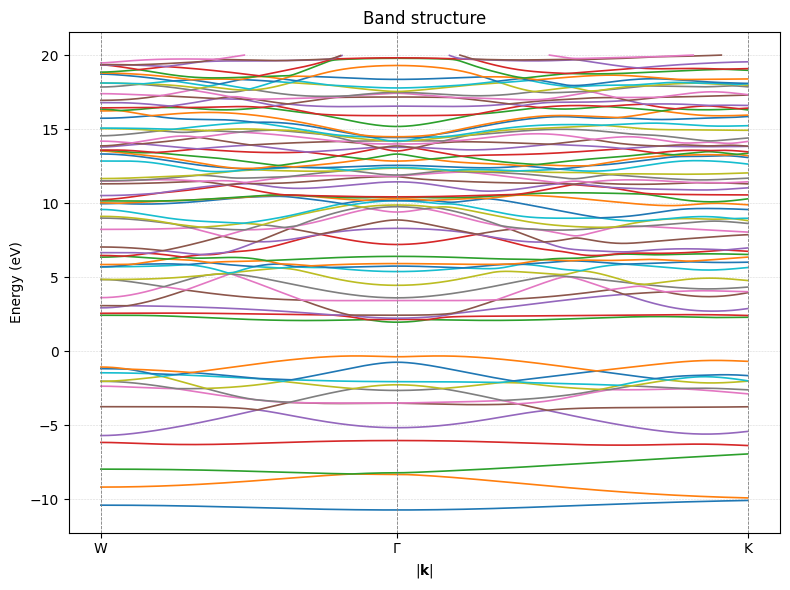

In [19]:
import numpy as np
import matplotlib.pyplot as plt


class BandStructurePlotter:

   
    def __init__(self, N: int, potential_profile: np.ndarray= None):
        self.N = N
        if potential_profile is None:
            self.V = np.asarray(potential_profile)
        
        self.k_path = None
        self.k_ticks = None      
        self.energies = None    

    # k space
    @staticmethod
    def _cumulative_distance(k_path):
        d = np.zeros(len(k_path))
        for i in range(1, len(k_path)):
            d[i] = d[i-1] + np.linalg.norm(k_path[i] - k_path[i-1])
        return d

    @staticmethod
    def _segment(a, b, n):
        """n points from a→b (excluding b)."""
        return np.linspace(a, b, n, endpoint=False)

    def build_k_path(self, corner_points, points_per_segment=200):
        """
        corner_points : list of 3-vectors (in Cartesian reciprocal space)
            e.g. [W, Γ, K, …].
        """
        k = []
        for p, q in zip(corner_points[:-1], corner_points[1:]):
            k.extend(self._segment(p, q, points_per_segment))
        k.append(corner_points[-1])          # include the last corner exactly
        self.k_path = np.array(k)
        self.k_ticks = {lbl: i*points_per_segment
                        for i, lbl in enumerate("".join((" " * (len(corner_points)-1))).split())}

    #eigen states
    def _compute_band_structure(self):
        assert self.k_path is not None, "call build_k_path() first"
        Nk = len(self.k_path)
        # get one eigen-spectrum just to know how many bands
        test_E = create_tight_binding(self.k_path[0], self.N)[0]
        Nb = test_E.size
        self.energies = np.empty((Nk, Nb))
        for i, kvec in enumerate(self.k_path):
            self.energies[i] = np.sort(create_tight_binding(kvec, self.N)[0].real)

    # plot
    def plot(self, energy_window=None, colour_cycle=None,
             k_labels=None, linewidth=1.2, figsize=(8, 6)):
        """
        energy_window : (Emin, Emax) tuple or None
            Energies outside are masked out (useful to hide surface bands).
        k_labels : dict {label: index} or None
            Override tick labels.  If None, W-Γ-K… order is auto-generated.
        """
        if self.energies is None:
            self._compute_band_structure()

        # x-axis
        k_x = self._cumulative_distance(self.k_path)

        # optional masking
        E = self.energies.copy()
        if energy_window is not None:
            Emin, Emax = energy_window
            E[(E < Emin) | (E > Emax)] = np.nan

        # plotting
        plt.figure(figsize=figsize)
        if colour_cycle:
            plt.gca().set_prop_cycle(color=colour_cycle)

        for band in range(E.shape[1]):
            plt.plot(k_x, E[:, band], lw=linewidth)

        # decorations
        plt.ylabel("Energy (eV)")
        plt.xlabel("$|\\mathbf{k}|$")
        plt.title("Band structure")
        plt.grid(True, ls="--", lw=0.4, alpha=0.5)

        # ticks at high-symmetry points
        if k_labels is None and self.k_ticks:
            k_labels = self.k_ticks
        if k_labels:
            tick_pos = [k_x[idx] for idx in k_labels.values()]
            for x in tick_pos:
                plt.axvline(x, color='grey', ls='--', lw=0.6)
            plt.xticks(tick_pos, list(k_labels.keys()))

        plt.tight_layout()
        plt.show()
# high symmetry points
a = 1.0
G  = np.array([0, 0])
W  = np.array([1/2, 1/2])
K  =np.array([3/4, 3/8])

# plot
N  = 1
plotter = BandStructurePlotter(N)
plotter.build_k_path([W, G, K], points_per_segment=200)

# custom tick dictionary (same indices you used before)
plotter.plot(energy_window=(-20, 20),
             k_labels={'W': 0,
                       r'$\Gamma$': 200,
                       'K': 400})


In [20]:
import numpy as np
from itertools import product
from multiprocessing import Pool, cpu_count

# create the k grid 
def make_mp_grid(Nk):
    """Return an (Nk3, 3) array of fractional k-vectors (0 … 1) in the 1st BZ."""
    shifts = np.linspace(0, 1, Nk, endpoint=False) + 0.5/Nk   
    klist  = np.array(list(product(shifts, repeat=2)))        

    return klist                                             

def analyzeRange(energies):
    largest_diff = [0,1,abs(energies[1] - energies[0])]
    for i,val in enumerate(energies[:-1]):
        diff = val - energies[i + 1]
        if abs(diff) > largest_diff[-1]:
            largest_diff[0] = i
            largest_diff[1] = i + 1
            largest_diff[-1] = abs(diff)
    
    return largest_diff[-1] + largest_diff[-1], 10
# helper method 
def frac_shift(k_frac, delta):
    return (k_frac + delta) % 1.0

#  effective-mass tensor around the CBM
def find_effective_mass(N, k_min_frac, Nk_coarse, band_idx,
                        resolution_factor=4, a=5.431e-10):


    delta_frac = 1.0 / (Nk_coarse * resolution_factor)        # we want a finer mesh size
    dk = (2*np.pi / a) * delta_frac                       


    k0 = np.asarray(k_min_frac, float)

    # get the good energy
    def E(k_frac):
        evs, _ = create_tight_binding(k_frac, N)
        energyTosend = evs[band_idx]
        print(energyTosend)
        return energyTosend
        

    #shift 
    ei = np.eye(2)

    # Hessian 
    H = np.zeros((2,2))
    for i in range(2):
        # second derivative along axis i
        kp = frac_shift(k0,  +delta_frac * ei[i])
        km = frac_shift(k0,  -delta_frac * ei[i])
        H[i,i] = (E(kp) + E(km) - 2*E(k0)) / dk**2

        # mixed derivatives
        for j in range(i+1, 2):
            kpp = frac_shift(k0, +delta_frac*ei[i] + delta_frac*ei[j])
            kmm = frac_shift(k0, -delta_frac*ei[i] - delta_frac*ei[j])
            kpm = frac_shift(k0, +delta_frac*ei[i] - delta_frac*ei[j])
            kmp = frac_shift(k0, -delta_frac*ei[i] + delta_frac*ei[j])
            H[i,j] = H[j,i] = (E(kpp)+E(kmm)-E(kpm)-E(kmp)) / (4*dk**2)

    # convert eV → J
    H_J = H * spc.e

    # m*  = hbar^2 *
    mstar_SI = spc.hbar**2 * np.linalg.inv(H_J)           # kg
    mstar_me = mstar_SI / spc.m_e                         # in m_e

    prin_m, prin_axes = np.linalg.eigh(mstar_me)
    return mstar_me, prin_m, prin_axes
N =1
def eval_k(k_frac):
    """return the good eigenvalues"""
    eigvals, _ = create_tight_binding(k_frac, N)    
    vbm = eigvals[eigvals <=  0.0].max()     
    cbm = eigvals[eigvals >=  0.0].min()
    return vbm, cbm, eigvals
def scan_full_BZ(self,Nk=20, store_all=True, n_jobs=None, a=5.431e-10,
                 res_factor=4):
    """
    Nk       : number of k-points per reciprocal-lattice axis (Nk³ total)
    store_all: if True, return the entire E(k) array (size Nk³ × Nb)
    n_jobs   : cores to use; default = all available
    """
 
    klist = make_mp_grid(Nk)
    nbands = len(create_tight_binding(np.zeros(2), N)[0])   # quick probe
    
    dk = 1 / Nk
    # ----- parallel diagonalisation -----
    n_jobs = n_jobs or cpu_count()
    with Pool(processes=n_jobs) as pool:
        results = pool.map(eval_k, klist, chunksize=len(klist)//n_jobs)

    # collect extrema
    vbm_E, cbm_E = -np.inf, np.inf
    vbm_data = cbm_data = None
    if store_all:
        all_E = np.empty((len(klist), nbands))
        print(all_E.shape)

    for idx, (v, c, eigs) in enumerate(results):
        if v > vbm_E:
            vbm_E      = v
            vbm_data   = (v, klist[idx], int(np.where(eigs==v)[0][0]))
        if c < cbm_E:
            
            cbm_E      = c
            cbm_data   = (c, klist[idx], int(np.where(eigs==c)[0][0]))
        if store_all:
            all_E[idx] = eigs

    
    
    
    Egap = cbm_E - vbm_E
    print(f"Fundamental gap = {Egap:.4f} eV")
    print("VBM : E = {:.4f} eV  at k_frac = {}".format(*vbm_data[:2]))
    print("CBM : E = {:.4f} eV  at k_frac = {}".format(*cbm_data[:2]))
    print("Direct gap" if np.allclose(vbm_data[1], cbm_data[1]) else "Indirect gap")
    mstar, prin_m, prin_ax = find_effective_mass(N, cbm_data[1], Nk,
                                                 cbm_data[2],
                                                 resolution_factor=res_factor,
                                                 a=a)
    print("\nEffective-mass tensor at CBM:\n", mstar)
    print("Principal massesₑ:\n", prin_m)

    if store_all:
        return (Egap, vbm_data, cbm_data,
                klist, all_E,
                mstar, prin_m, prin_ax)
    return Egap, vbm_data, cbm_data, mstar, prin_m, prin_ax


Egap, vbm, cbm, klist, allE, M, m_prin, axes = scan_full_BZ(1, Nk=30, store_all=True, res_factor=6)

print("\ndelta-valley:  m_l = {:.3f}  m_t = {:.3f}  (in me)".format(m_prin.max(), m_prin.min()))



(900, 80)
Fundamental gap = 2.2819 eV
VBM : E = -0.3257 eV  at k_frac = [0.08333333 0.05      ]
CBM : E = 1.9562 eV  at k_frac = [0.01666667 0.98333333]
Indirect gap
1.956928467572946
1.9565711194607704
1.9561705562685237
1.9584256114724812
1.958425611472491
1.9565905984980865
1.9558725411352347
1.9565711194607693
1.9569284675729475
1.9561705562685237

Effective-mass tensor at CBM:
 [[ 2.63090269 -2.49134103]
 [-2.49134103  2.63090269]]
Principal massesₑ:
 [0.13956166 5.12224371]

delta-valley:  m_l = 5.122  m_t = 0.140  (in me)


In [ ]:
# broken 

def getTheDOS(E, N, sigma):
    def gaussian(En):
        return 1 / np.sqrt(2 * np.pi * sigma) * np.exp(-(E - En)**2 / (2 * sigma))
    D = 0
    for kx in np.linspace(-1,1,50):
        kx = 2 *np.pi / a * kx
        for ky in np.linspace(-1,1,50):
                energies = create_tight_binding(np.array([kx, ky, 0]), N, potentialProfile)[0]
                for en in energies:
                    D += gaussian(en)
            
    
    return D
        

def getFermiLevel(N, dos, dosE):
    kbT = 0.0257   
    fermi = lambda x: 1.0 / (1.0 + np.exp(x / kbT))
    
    def integralGuess(x):
        dE = dosE[1] - dosE[0]
    
        occupancy = fermi(dosE - x)  
    
        return dE * np.sum(dos * occupancy)
    
    numberOfElectrons = 4 * N * 8

    E_F = 0.55
    err = integralGuess(E_F) - numberOfElectrons

    step = 0.01
    while abs(err) > 2.0:
        if err < 0:

            E_F -= step
        else:
            E_F += step
        
        err = integralGuess(E_F) - numberOfElectrons
    
    return E_F

    

In [ ]:
# test code for DOS
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as spc

hbar = 1       
m    = 1
q    = 1
L    = 1
Ec = 1 

Lz   = 20         

Nk = 40000

k = np.linspace(-np.pi / L, np.pi / L, Nk)
Ek = hbar**2 * k**2 / (2 * m) + Ec          # dispersion

sigma = .001
E = np.linspace(Ek.min(), Ek.max(), 1000)    # energy axis
dos = np.sum(np.exp(-(E[:, None] - Ek[None, :])**2 / (2 * sigma**2)), axis=1)
dos /= np.sqrt(2 * np.pi) * sigma      # normalize Gaussians
realdos = m * L / hbar / np.pi * np.sqrt((1 / (2 * m * (E - Ec))))




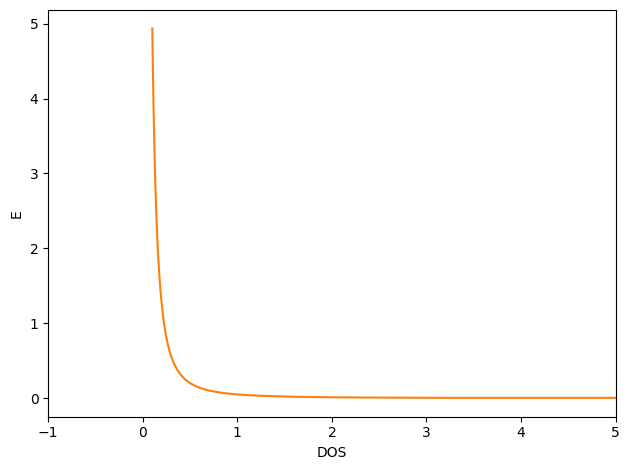

In [ ]:
#print(dos)
plt.plot(dos, (E - Ec)/q)


plt.plot(realdos, (E - Ec)/q)
plt.xlabel('DOS')
plt.xlim((-1,5))
plt.ylabel('E')
plt.tight_layout()
plt.show()

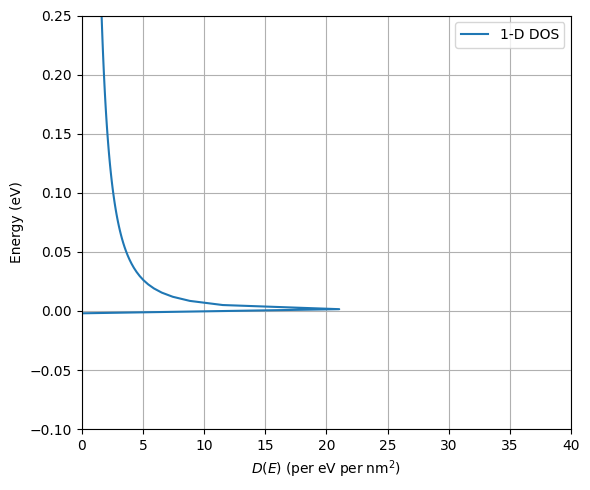

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- physical constants (SI; energies stay in eV) ---
hbar = 1.055e-34       # J·s
m    = 9.110e-31       # kg
q    = 1.602e-19       # C   (eV → J conversion factor)
L    = 1e-9            # 1 nm in m


Lz   = 20e-9           # m   (set 5e‑9 for case (a))

# sub‑band spacing
E0 = (hbar**2 * np.pi**2) / (2 * q * m * Lz**2)   # eV

# energy axis (eV)
E = np.linspace(-0.1, 0.25, 101)

# Heaviside steps θ(E) and θ(E – E_p)
theta_E  = (E > 0).astype(float)                  # θ(E)
D2       = np.zeros_like(E)                       # initialise 2‑D DOS accumulator

for p in range(1, 26):                            # p = 1 … 25
    EE       = E - (p * p * E0)
    theta_EE = (EE > 0).astype(float)             # θ(E – E_p)

    # 1‑D, 2‑D, 3‑D DOS (1‑D term D1 is unused later but shown for completeness)
    D1 = np.zeros_like(E)
    mask = E > 0                      # avoid E = 0 exactly
    D1[mask] = (L * q * m /
                (np.pi * hbar) *
                (2 * m * q * E[mask])**(-0.5))

    D2 += (L**2 * q * m * theta_EE) / (2 * np.pi * hbar**2)

    if p == 25:                                   # save last‑pass 3‑D term
        D3 = (L**3 * q * m * theta_E /
               (2 * np.pi**2 * hbar**3) *
               np.sqrt(2 * m * q * np.maximum(E, 0)))

# --- plotting (matches MATLAB order: x = DOS, y = E) ---
plt.figure(figsize=(6, 5))
plt.plot(D1,              E, label="1‑D DOS", linewidth=1.5)
#plt.plot(D3 * Lz / L,     E, label="3‑D DOS × (Lz/L)", linewidth=1.5)

plt.xlim(0, 40)           # part (b) limits; use (0,10) for part (a)
plt.ylim(-0.1, 0.25)
plt.xlabel(r"$D(E)\;(\mathrm{per\;eV\;per\;nm^2})$")
plt.ylabel("Energy (eV)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:



def getFermiLevel(N, dos, dosE):
    kbT = 0.0257   
    fermi = lambda x: 1.0 / (1.0 + np.exp(x / kbT))
    
    def integralGuess(x):
        dE = dosE[1] - dosE[0]
    
        occupancy = fermi(dosE - x)  
    
        return dE * np.sum(dos * occupancy)
    
    numberOfElectrons = 1

    E_F = 0.55
    err = integralGuess(E_F) - numberOfElectrons

    step = 0.01
    while abs(err) > 2.0:
        if err < 0:

            E_F -= step
        else:
            E_F += step
        
        err = integralGuess(E_F) - numberOfElectrons
    
    return E_F



In [ ]:
 
energies = np.linspace(-1,1, 501)
def getFermiLevel(N, dos, dosE):
    kbT = 0.0257   
    fermi = lambda x: 1.0 / (1.0 + np.exp(x / kbT))
    
    def integralGuess(x):
        dE = dosE[1] - dosE[0]
    
        occupancy = fermi(dosE - x)  
    
        return dE * np.sum(dos * occupancy)
    
    numberOfElectrons = 1

    E_F = 0.55
    err = integralGuess(E_F) - numberOfElectrons

    step = 0.01
    while abs(err) > 2.0:
        if err < 0:

            E_F -= step
        else:
            E_F += step
        
        err = integralGuess(E_F) - numberOfElectrons
    
    return E_F

### old sp3

In [ ]:

def create_tight_binding(k, N, potentialProfile):
    kx,ky,kz = k
    unitCell = UnitCellGeneration(N)
    unitNeighbors = unitCell.neighborTable()
    numSilicon = len(unitNeighbors.keys())
    size = numSilicon* 4 # sp3
    A = np.zeros((size, size), dtype=complex)    
    
    atomToIndex = {}
    indexToAtom = {}
    for atom_index,atom in enumerate(unitNeighbors):
        atomToIndex[atom] = atom_index
        indexToAtom[atom_index] = atom
    
  
    orbitals = ['s', 'px', 'py', 'pz']
    
    # old code with no dangling bonds 
    """for atom_index in range(numSilicon):
        for orbIndex, orbital in enumerate(orbitals):
            index = atom_index * 4 + orbIndex
            #print(orbital)
            A[index, index] += E[orbital]"""

            
    for atom_idx, atom in indexToAtom.items():
        hybridizationMatrix = H_sp3_explicit.copy() 

        for delta in unitCell.dangling_bonds(atom):
            signs = np.array([1/4] + list(delta)) * 4
            h = UnitCellGeneration.determine_hybridization(signs)
            hybridizationMatrix[h, h] += E['sp3']          # increase the energy of dangling states 
        
        # if there are no dangling bonds this returns the standard diag matrix with onsite energies 
        onsiteMatrix = U_orb_to_sp3 @ hybridizationMatrix @ U_orb_to_sp3.T # go back to orbital basis 
        A[atom_idx*4:(atom_idx+1)*4, atom_idx*4:(atom_idx+1)*4] = onsiteMatrix
    
    for atom_index in range(numSilicon):
        atom = indexToAtom[atom_index]
        neighbors = unitNeighbors[atom]
        for orbitalIndex, orbital in enumerate(orbitals):
            index_i = atom_index * 4 + orbitalIndex
            
            effectiveZinPotential = int(atom.z)
            
            A[index_i,index_i] += potentialProfile[effectiveZinPotential]
            
            for neighbor in neighbors.keys():
                delta = neighbors[neighbor][0]
                l,m,n = neighbors[neighbor][1:]
                phase = np.exp(1j * (kx*delta[0] + ky*delta[1])) # blochs theorem does not work 
                
                neighbor_index = atomToIndex[neighbor]       
                
                for secOrbitalIndex, secondOrbital in enumerate(orbitals):
                    index_j = neighbor_index * 4 + secOrbitalIndex
                    
                    hop = SK[(orbital, secondOrbital)](l, m, n, V)
                        
                    A[index_i,index_j] += hop * phase   
            
                
        dagger = lambda A: np.conjugate(A.T)
    if not np.allclose(A, dagger(A)):
        print("H isnt Hermitian")

    eigvals,eigv = np.linalg.eigh(A)
    return eigvals, eigv, A